# sample distribution

In [13]:
from collections import Counter
import os
import xmltodict

import matplotlib.pylab as plt
%matplotlib inline

In [14]:
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('image/archive/'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]=="png":
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=='xml':
            xml_names.append(filename)
        else:
            continue



In [15]:
path_annotations="image/archive/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)


dict_keys(['with_mask', 'mask_weared_incorrect', 'without_mask']) 
 dict_values([3232, 123, 717])


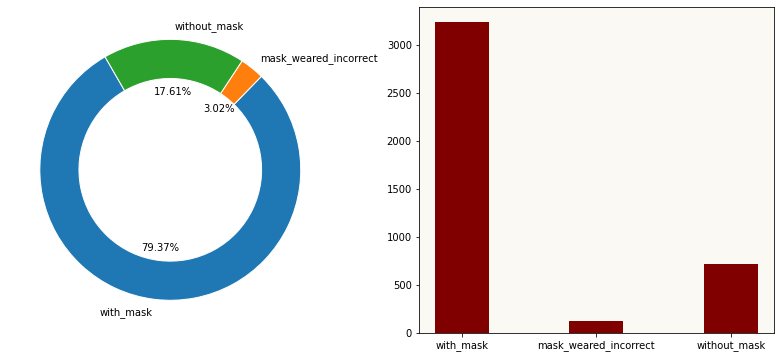

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

### conclusion:
data distribution is imbalanced, which should be paid more attention in the training section


&nbsp;
## samples ---- training and testing data
**furthermore, due to the property of dataset ---  which includes the positions of bounding box and the corresponding label (mask and without mask).
so these information can be used, each bounding box can be a single sample to train the model.**


## **visualization** --- mask / without mask image

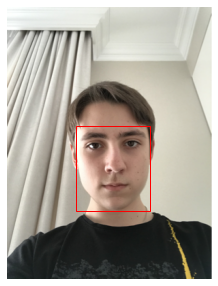

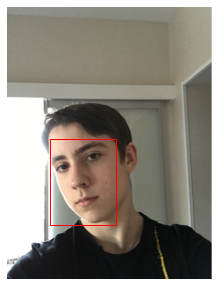

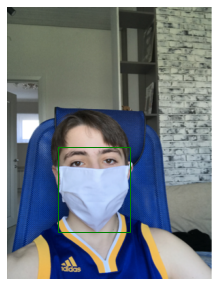

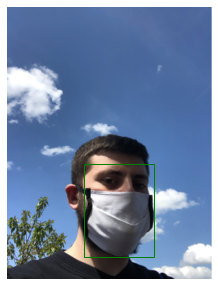

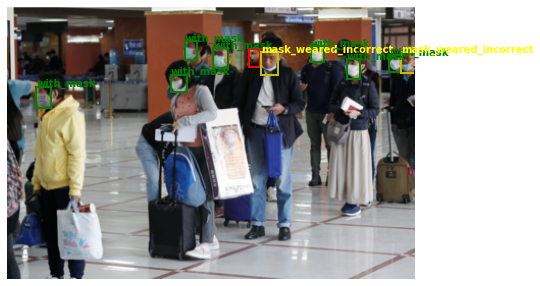

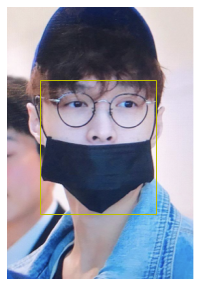

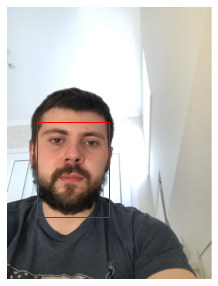

In [17]:
path_image="/Users/liu/Desktop/github/CV/image/archive/images/"
def face_cas(img):
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_image+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                # ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

fun_images = img_names.copy()
for i in range(1,8):
    face_cas(fun_images[i])

## preprocess training and testing data

In [18]:
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2}

In [19]:
## extract  sub-image of person with mask or without mask
## transform those sub-image into tensor

## finally, for each image, storing in the list [[tensor_image, tensor_label]]

## all of them store in  ""mydataset""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import torch.optim as optim


def dataset_creation(image_list):
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))

    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

mydataset=dataset_creation(img_names)

In [20]:
mydataset[0]

[tensor([[[0.4941, 0.4941, 0.4980,  ..., 0.5255, 0.5255, 0.5255],
          [0.4941, 0.4941, 0.4980,  ..., 0.5255, 0.5255, 0.5255],
          [0.4941, 0.4941, 0.4980,  ..., 0.5294, 0.5294, 0.5294],
          ...,
          [0.5373, 0.5373, 0.5333,  ..., 0.0980, 0.0980, 0.0980],
          [0.5412, 0.5412, 0.5373,  ..., 0.0980, 0.0980, 0.0980],
          [0.5412, 0.5412, 0.5373,  ..., 0.0980, 0.0980, 0.0980]],
 
         [[0.3412, 0.3412, 0.3451,  ..., 0.3725, 0.3725, 0.3725],
          [0.3412, 0.3412, 0.3451,  ..., 0.3725, 0.3725, 0.3725],
          [0.3412, 0.3412, 0.3451,  ..., 0.3765, 0.3765, 0.3765],
          ...,
          [0.5882, 0.5882, 0.5843,  ..., 0.1333, 0.1333, 0.1333],
          [0.5882, 0.5882, 0.5843,  ..., 0.1333, 0.1333, 0.1333],
          [0.5882, 0.5882, 0.5843,  ..., 0.1333, 0.1333, 0.1333]],
 
         [[0.2118, 0.2118, 0.2157,  ..., 0.2431, 0.2431, 0.2431],
          [0.2118, 0.2118, 0.2157,  ..., 0.2431, 0.2431, 0.2431],
          [0.2118, 0.2118, 0.2157,  ...,

### Splitting Dataset into Training and Test Set¶

In [21]:
train_size=int(len(mydataset)*0.7)
test_size=len(mydataset)-train_size
print('Length of dataset is', len(mydataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

Length of dataset is 4072 
Length of training set is : 2850 
Length of test set is : 1222


**split mydataset into training and testing dataset**

In [22]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

In [23]:
len(trainset)

2850

In [24]:
train_dataloader =DataLoader(dataset=trainset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader =DataLoader(dataset=testset,batch_size=32,shuffle=True,num_workers=4)

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")
device

device(type='cpu')

In [26]:
import sys
train_features, train_labels = (next(iter(train_dataloader)))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 226, 226])
Labels batch shape: torch.Size([32])


(32, 3, 226, 226)


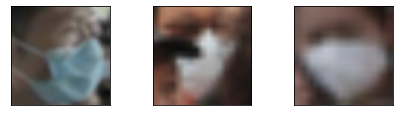

In [27]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

train_features_np=train_features.numpy()
print((train_features_np).shape)
fig=plt.figure(figsize=(25,4))
for idx in np.arange(3):
    ax=fig.add_subplot(2,int(20/2),idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(train_features_np[idx],(1,2,0)))

# training model

In [33]:
model=models.resnet34(pretrained=True)

In [34]:
for param in model.parameters():
    param.requires_grad=False

In [35]:
import torch.nn as nn
n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

model.fc.out_features=last_layer
print('reinitialize model with output features as 3 :', model.fc.out_features)

reinitialize model with output features as 3 : Linear(in_features=512, out_features=3, bias=True)


In [36]:
features_resnet34 = []
for key,value in model._modules.items():
    features_resnet34.append(value)

features_resnet34

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [37]:
conv_param = 64 * 128 * 3 * 3
print(' Number of Parameters for conv2D is :', conv_param )

 Number of Parameters for conv2D is : 73728


In [38]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

# training

In [74]:
param.requires_grad=True
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

In [75]:
from time import time as T
init = T()
for epoch in range(1,5):
    running_loss = 0.0
    train_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):

        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()

        #inputs = inputs.to(device)
        #labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 20 == 19:

                print("Epoch {}, batch {}, training loss {}".format(epoch, i+1,running_loss/20),'>>>> run ',T()-init,' s')

        running_loss = 0.0



print('\nFinished Training')


Epoch 1, batch 60, training loss 0.4603917598724365 >>>> run  408.40771102905273  s
Epoch 1, batch 80, training loss 0.44346208572387696 >>>> run  542.9623429775238  s
Epoch 2, batch 20, training loss 0.4251844882965088 >>>> run  746.6649479866028  s
Epoch 2, batch 40, training loss 0.43937125205993655 >>>> run  881.3291590213776  s
Epoch 2, batch 60, training loss 0.41669764518737795 >>>> run  1014.5631601810455  s
Epoch 2, batch 80, training loss 0.43093719482421877 >>>> run  1148.3325769901276  s
Epoch 3, batch 20, training loss 0.40934133529663086 >>>> run  1349.9684569835663  s
Epoch 3, batch 40, training loss 0.40273494720458985 >>>> run  1483.302235841751  s
Epoch 3, batch 60, training loss 0.39324862957000734 >>>> run  1617.4623198509216  s
Epoch 3, batch 80, training loss 0.38384010791778567 >>>> run  1751.5282068252563  s
Epoch 4, batch 20, training loss 0.3781177759170532 >>>> run  1951.7779850959778  s
Epoch 4, batch 40, training loss 0.3590407848358154 >>>> run  2085.65592

KeyboardInterrupt: 

## save model

In [76]:
import os
try:
    os.makedirs("trained_model/resNet")
except:
    print('the direction has already existed')

torch.save(model,open("trained_model/resNet/resnet_model_face_mask","wb")) # saving the trained model.

# torch.save(model.state_dict(), 'trained_model/resNet/res')

the direction has already existed


## load model

In [39]:
import torch
device = torch.device("cuda")
model_af_finT=torch.load(open("trained_model/resNet/resnet_model_face_mask","rb")) #loading the model

In [40]:
model_af_finT.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

###

In [41]:
# import torch.nn as nn
# model_af_finT = models.resnet34(pretrained=True)
#
# n_inputs=model_af_finT.fc.in_features
# last_layer=nn.Linear(n_inputs,3)
# model_af_finT.fc.out_features=last_layer
#
# model_af_finT.load_state_dict(torch.load("trained_model/resNet/res"))
# model_af_finT.eval()

## testing

In [45]:
for epoch in range(1,2):
    running_loss = 0.0
    test_losses = []
    for i, (inputs, labels) in enumerate(test_dataloader):

        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()


        # optimizer.zero_grad()
        with torch.no_grad():
            outputs = model_af_finT(inputs)
            loss = criterion(outputs, labels)
            print(torch.max(outputs,1))
            # loss.backward()
            # optimizer.step()
            print(outputs.size())
            running_loss += loss.item()




        print("Epoch {}, batch {}, test loss {}".format(epoch, i+1,running_loss/20))
        break
        running_loss = 0.0

torch.return_types.max(
values=tensor([5.1154, 7.0670, 3.5465, 5.2330, 3.1277, 3.3231, 3.5579, 4.2411, 6.5616,
        4.2949, 5.1112, 5.6954, 7.2791, 5.8563, 2.5105, 3.2365, 4.7240, 4.8737,
        3.0488, 4.0097, 5.5477, 3.6169, 4.4535, 6.2566, 4.0568, 3.5919, 4.2324,
        5.1399, 4.8796, 4.3598, 6.8188, 3.9821]),
indices=tensor([447, 652, 696, 442, 728, 682, 579, 682, 200, 884, 176, 999, 570, 484,
        291, 896, 583, 672, 799, 583, 741, 704, 805, 515,  60, 543, 481,  60,
        739, 583, 652, 672]))
torch.Size([32, 1000])
Epoch 1, batch 1, test loss 0.5011923313140869


# prediction

['without1.jpeg', 'test1.jpeg', 'test2.jpeg', 'without4.jpeg', 'test3.jpeg', 'without3.jpeg', 'test4.jpeg', 'without2.jpeg']


([tensor([[[0.2392, 0.2392, 0.2431,  ..., 0.2510, 0.2510, 0.2510],
           [0.2392, 0.2392, 0.2431,  ..., 0.2510, 0.2510, 0.2510],
           [0.2431, 0.2431, 0.2471,  ..., 0.2510, 0.2510, 0.2510],
           ...,
           [0.3608, 0.3216, 0.2627,  ..., 0.1725, 0.1686, 0.1686],
           [0.2314, 0.2196, 0.2039,  ..., 0.1725, 0.1686, 0.1686],
           [0.1647, 0.1804, 0.1961,  ..., 0.1725, 0.1686, 0.1686]],
  
          [[0.2902, 0.2902, 0.2941,  ..., 0.2863, 0.2863, 0.2863],
           [0.2902, 0.2902, 0.2941,  ..., 0.2863, 0.2863, 0.2863],
           [0.2941, 0.2941, 0.2980,  ..., 0.2863, 0.2863, 0.2863],
           ...,
           [0.3569, 0.3176, 0.2627,  ..., 0.1804, 0.1804, 0.1804],
           [0.2118, 0.2000, 0.1804,  ..., 0.1804, 0.1804, 0.1804],
           [0.1294, 0.1451, 0.1608,  ..., 0.1804, 0.1804, 0.1804]],
  
          [[0.3216, 0.3216, 0.3255,  ..., 0.3137, 0.3137, 0.3137],
           [0.3216, 0.3216, 0.3255,  ..., 0.3137, 0.3137, 0.3137],
           [0.3255, 0.

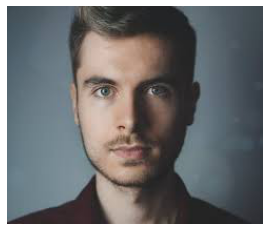

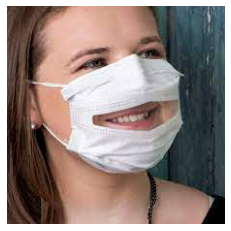

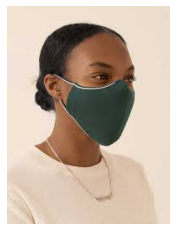

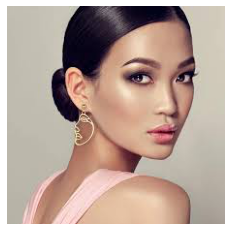

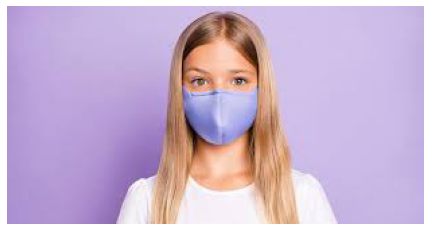

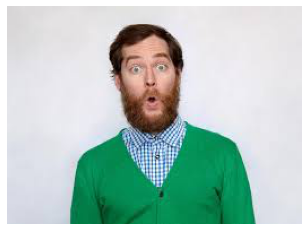

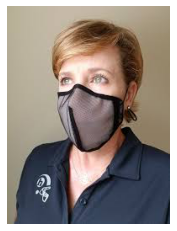

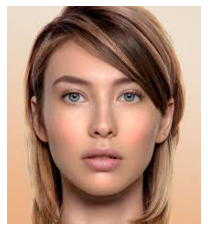

In [4]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

import torch
from torchvision import datasets,transforms,models
from PIL import Image
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2}
map_ = {0:"with_mask",1:"without_mask",2:"mask_weared_incorrect"}

def prep_image(path):
    img_small=[]
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if os.path.join(dirname, filename)[-4:]=="jpeg":
                img_small.append(filename)
            else:
                continue
    image_tensor = []
    label_tensor=[]

    my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

    print(img_small)
    for i in img_small:
        image=Image.open(path+i).convert("RGB")
        fig,ax=plt.subplots(1)
        ax.axis("off")
        fig.set_size_inches(8,4)
        plt.imshow(image)
        ax.imshow(image)
        # ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
        image_tensor.append(my_transform(image))




        if 'without' in i:
            label  = 1
        else:
            label = 0
        label_tensor.append(torch.tensor(label))

        final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)

a = prep_image('/Users/liu/Desktop/github/CV/image/archive/small_imageset/')

a


In [7]:
from torch.utils.data import Dataset,DataLoader
dataloader =DataLoader(dataset=a)
features,labels = (next(iter(dataloader)))

print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature batch shape: torch.Size([1, 3, 226, 226])
Labels batch shape: torch.Size([1])


In [81]:
import cv2
import matplotlib.patches as patches
model=model.eval()
def testing(filepath):
    configut=["with_mask","without_mask","mask_weared_incorrect"]
    img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    newimage=Image.open(filepath).convert("RGB")
    bndbox=detect.detect_faces(img)
    if len(bndbox)==1:
        image_pred=trans(bndbox[0],newimage).unsqueeze(0)
        _, pred=torch.max(model(image_pred.to(device)),1)
        tag_plot(bndbox,filepath,predicted=pred)
    else:
        predicted=[]
        for i in bndbox:
            image_pred=trans(i,newimage).unsqueeze(0)
            _, pred=torch.max(model(image_pred.to(device)),1)
            predicted.append(pred)
        tag_plot(bndbox,filepath,predicted)

In [ ]:
testing(path_im+imagenames[118])